<a href="https://colab.research.google.com/github/AlbertRasinski/Face_Detection_Machine_Learning/blob/main/cpo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading tools to measure time and memory usage

In [ ]:
!pip install ipython-autotime
%load_ext autotime
!pip install wandb

Importing the necessary packages

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from google.colab import drive
import pickle
from IPython.display import Image
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import cv2
from google.colab.patches import cv2_imshow
import wandb

ModuleNotFoundError: ignored

Connecting to the Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Loading image data

In [ ]:
trainingDatasetPath = "/content/drive/MyDrive/data/training"
validationDatasetPath = "/content/drive/MyDrive/data/validation"
testingDatasetPath = "/content/drive/MyDrive/data/testing"

trainingDatasetImageGenerator = ImageDataGenerator(rescale=1./255,
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.2,
  zoom_range=0.3,
  horizontal_flip=True,
  fill_mode='nearest')

validationDatasetImageGenerator = ImageDataGenerator(rescale=1./255,
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.2,
  zoom_range=0.3,
  horizontal_flip=True,
  fill_mode='nearest')

testingDatasetImageGenerator = ImageDataGenerator(rescale=1./255)

trainingDataset = trainingDatasetImageGenerator.flow_from_directory(trainingDatasetPath, target_size=(128,128), batch_size=64, class_mode='binary')
validationDataset = validationDatasetImageGenerator.flow_from_directory(validationDatasetPath, target_size=(128,128), batch_size=64, class_mode='binary')
testingDataset = testingDatasetImageGenerator.flow_from_directory(testingDatasetPath, target_size=(128,128), batch_size=64, class_mode='binary')

Show sample images

In [ ]:
plt.imshow(trainingDataset[0][0][0])
plt.imshow(validationDataset[0][0][0])
plt.imshow(testingDataset[0][0][0])

Preparing the structure of the CNN model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu, input_shape=(128, 128, 3)),
  tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
  tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu),
  tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu),
  tf.keras.layers.MaxPooling2D((2,2), padding='same'),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.compile(loss='binary_crossentropy',
  optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
  metrics=['binary_accuracy'])

Show the structure of the CNN model

In [ ]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Learn model, save model and plot the results

In [ ]:
wandb.init()
history = model.fit(
  trainingDataset,
  epochs=10,
  validation_data=validationDataset,
  verbose=1
  )

export_model_dir = '/content/drive/MyDrive/model'
model.save(export_model_dir)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Load saved model from Google Drive

In [ ]:
export_model_dir = '/content/drive/MyDrive/model'
model = tf.keras.models.load_model(export_model_dir)

Evaluate model

In [ ]:
wandb.init()
resultsEvaluate = model.evaluate(testingDataset, verbose=1)

print('accuracy:')
print(resultsEvaluate[1])
print('loss:')
print(resultsEvaluate[0])

Show confusion matrix

In [ ]:
prediction = np.argmax(model.predict_generator(testingDataset, verbose=1), axis=1)

confusionMatrix = confusion_matrix(testingDataset.classes, prediction)

classes = []
for key in testingDataset.class_indices:
  classes.append(key)

plt.imshow(confusionMatrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
numberOfClasses = np.arange(len(classes))
plt.xticks(numberOfClasses, classes, rotation=45)
plt.yticks(numberOfClasses, classes)

confusionMatrix = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
confusionMatrix = np.around(confusionMatrix, decimals=10)
confusionMatrix[np.isnan(confusionMatrix)] = 0.0
thresh = confusionMatrix.max() / 2.

for i, j in itertools.product(range(confusionMatrix.shape[0]), range(confusionMatrix.shape[1])):
  plt.text(j, i, confusionMatrix[i, j],
           horizontalalignment="center",
           color="white" if confusionMatrix[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Use model to predict a given image from a desktop

Saving 57019.jpg to 57019.jpg
[[4.9477504e-25]]


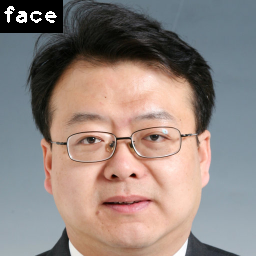

In [ ]:
predictFile = files.upload()

fileName = list(predictFile.keys())[0]

img = image.load_img(fileName, target_size=(128, 128))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)
img = img / 255
imgOpenCV = cv2.imread(fileName)
imgOpenCV = cv2.resize(imgOpenCV, (256,256))

result = model.predict(img, batch_size=1)
print(result)
if (result[0][0] < 0.5):
  imgOpenCV = cv2.rectangle(imgOpenCV, (0,0),(62, 32), (0, 0, 0), -1)
  imgOpenCV = cv2.putText(imgOpenCV, "face", (2,22), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
else:
  imgOpenCV = cv2.rectangle(imgOpenCV, (0,0),(102, 32), (0, 0, 0), -1)
  imgOpenCV = cv2.putText(imgOpenCV, "no face", (2,22), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

cv2_imshow(imgOpenCV)